<a href="https://colab.research.google.com/github/CristianMorasso/InceptionTimeXICaRL/blob/main/InceptionTimeXiCarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADVANCED PROGRAMMING PROJECT
## CONTINUAL LEARNING WITH ICARL

In this colab you can find a small implementation of:
- InceptionTime Network for TimeSeries Classification
- Avalanche Benchmark to evaluate ICaRL method in Classification task

</br>
</br>
Author: Cristian Morasso

Lib used:
- Avalanche:  https://github.com/ContinualAI/avalanche/tree/master
- TSAI:       https://github.com/timeseriesAI/tsai
- aeon:       https://github.com/aeon-toolkit/aeon


On their github you can find interesting tutorials.

In [13]:
!pip install avalanche-lib==0.3.1 >> /dev/null

In [14]:
!pip install aeon >> /dev/null

In [15]:

stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [16]:
from tsai.all import *
import sklearn.metrics as skm
import pandas as pd
my_setup()

os              : Linux-5.15.109+-x86_64-with-glibc2.35
python          : 3.10.6
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.1+cu118
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : N/A


In [17]:
import seaborn as sns
sns.set_theme()

# 📚 Some theory

&emsp; &emsp;Before talking specifically about the methods, a note about the architecture, which is based on **singlehead**, I choose this approach because I known in advance the number of classes.

**Singlehead**

&emsp; &emsp;In this setting, one unified model shall be used across all tasks.

At test time, we can process the data whitout keeping track of what task this data occured in, which is a more realistic setting.


## [iCaRL](https://arxiv.org/abs/1611.07725)


&emsp; &emsp;Incremental Classifier and Representation Learning is a repay or rearshal method to avoid the **catastrophic forgetting** and to do that it stores some samples of all previous experiences.

iCaRL base point:

- classification by a **nearest-mean-of-exemplars** rule,
- prioritized exemplar selection based on herding,
- representation learning using knowledge distillation
and prototype rehearsal

#### Nearest-mean-of-exemplars & prioritized exemplar selection

&emsp; &emsp;To predict a label, 𝚢*, for a new sample, 𝑋, it computes a prototype vector for each class observed so far.

It also computes the feature vector of the sample that should be classified and assigns the class label with most similar prototype.

Then he computes the 𝐾 nearet examples for each class and add them to the next dataset.

It also computes the feature vector of the data that should be classified and assigns the class label with most similar prototype.

#### Representation learning

&emsp; &emsp;First, iCaRL constructs an augmented training set consisting of the currently available training examples together with the stored
exemplars.

Next, the current network is evaluated for each example and the resulting network outputs for all previous
classes are stored (not for the new classes, since the network
has not been trained for these, yet).

Finally, the network parameters are updated by minimizing a loss function that for each new image encourages the network to output the correct class indicator for new classes (classification loss), and for old classes, to reproduce the scores stored in the previous step (distillation loss).

## [INCEPTION TIME NETWORK](https://arxiv.org/abs/1909.04939)
![Inception NET](https://github.com/CristianMorasso/InceptionTimeXICaRL/blob/main/imgs/InceptionTimeNet.png?raw=true)
This one is the architecture of the network, basically its a series of [Inception Modules](#INCEPTION-MODULE).

## INCEPTION MODULE
![Inception Module](https://github.com/CristianMorasso/InceptionTimeXICaRL/blob/main/imgs/InceptionTimeModule.png?raw=true)
The Inception Module in a nutshell:
1. given the input (multivariate or univariate), it filters it with a Bottleneck - Conv 1x1xk k filters, reducing the number of variables usually -
2. process the bottleneck output with 3 different filters - usually {10,20,40} (parameter _ks_ in the code)-
3. then merges them with a MaxPooling input filtered with the bottleneck filters.

The main idea behind this net is the **receptive field**, with different filters and multiple modules this net is able to "scan" the input looking for different length patterns.  

# 💻 IMPLEMENTATION

&emsp; &emsp;As we said the InceptionTime network is a series of InceptionTime Modules (this series is called _InceptionTime Block_)

In [18]:
__all__ = ['InceptionModule', 'InceptionBlock', 'InceptionTime']

# InceptionModule is the Main component of this net, defined as follow:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        """
        ni: input variables\n
        nf: output variables (bottleneck size)\n
        ks: kernel size (with 40 you get 3 filters {10,20,40}, ks/1, ks/2, ks/4)\n
        bottleneck: boolean if the bottleneck is active
        """
        ks = [ks // (2**i) for i in range(3)] #filter dimentions (KS means kernel size)
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop #conv1d for the bottleneck layer
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks]) #list of conv layer for each filter ks list
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])  #2 layer fist max pooling (3input emulate a windows imo) and conv for all inputs
        self.concat = Concat()
        self.bn = BN1d(nf * 4)  #batch norm
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, ks=40, **kwargs):
        """
        ni: input variables\n
        nf: output variables (bottleneck size)\n
        residuals: boolean for residual feature\n
        depth: number of inception Modules in the block\n
        ks: Kernel size for inception Module\n
        """

        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()

        for d in range(depth):  #queue of inception module as the deep that we prefer
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, ks, **kwargs))
            if self.residual and d % 3 == 2:
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None)) #add a residual process every third inceptionModule
        self.add = Add()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))  #process and save the residual to pass to future inceptionModule
        return x


@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs)
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out)
        self.feature_extractor = nn.Sequential(self.inceptionblock, self.gap)
        self.classifier = self.fc
    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

# 🔢 DATA

We are using `UWaveGestureLibrary` dataset, an UCR ds, [link here](http://www.timeseriesclassification.com/description.php?Dataset=UWaveGestureLibrary).

We chose _UWaveGestureLibrary_ because it has 8 classes (gesture representation), enough to do binary classification with continual learning.


![UWaveGestureLibrary](https://github.com/CristianMorasso/InceptionTimeXICaRL/blob/main/imgs/UWaveGestureLibrary.jpg?raw=true)

##Importing the data

&emsp; &emsp;Now we have to load the dataset to classify, we will use an UCR dataset (tsai lib have a function to load UCR datasets, `get_UCR_multivariate_list()`).
</br>
With `get_UCR_data()` you can download the ds splitted in train and test, that will be good for the avalanche benchmark.
</br>


**NOTE:** The function `get_UCR_data()` has been modified form the original because the website for ds download is on update.

In [19]:
from tsai.data.external import _ts2df

def get_UCR_data(dsid, path='.', parent_dir='data/UCR', on_disk=True, mode='c', Xdtype='float32', ydtype=None, return_split=True, split_data=True,
                 force_download=False, verbose=False):
    dsid_list = [ds for ds in UCR_list if ds.lower() == dsid.lower()]
    assert len(dsid_list) > 0, f'{dsid} is not a UCR dataset'
    dsid = dsid_list[0]
    return_split = return_split and split_data # keep return_split for compatibility. It will be replaced by split_data
    if dsid in ['InsectWingbeat']:
        warnings.warn(f'Be aware that download of the {dsid} dataset is very slow!')
    pv(f'Dataset: {dsid}', verbose)
    full_parent_dir = Path(path)/parent_dir
    full_tgt_dir = full_parent_dir/dsid
#     if not os.path.exists(full_tgt_dir): os.makedirs(full_tgt_dir)
    full_tgt_dir.parent.mkdir(parents=True, exist_ok=True)
    if force_download or not all([os.path.isfile(f'{full_tgt_dir}/{fn}.npy') for fn in ['X_train', 'X_valid', 'y_train', 'y_valid', 'X', 'y']]):
        # Option A
        src_website = f"https://timeseriesclassification.com/aeon-toolkit"
        decompress_from_url(f'{src_website}/{dsid}.zip', target_dir=full_tgt_dir, verbose=verbose)
        if dsid == 'DuckDuckGeese':
            with zipfile.ZipFile(Path(f'{full_parent_dir}/DuckDuckGeese/DuckDuckGeese_ts.zip'), 'r') as zip_ref:
                zip_ref.extractall(Path(parent_dir))
        if not os.path.exists(full_tgt_dir/f'{dsid}_TRAIN.ts') or not os.path.exists(full_tgt_dir/f'{dsid}_TRAIN.ts') or \
        Path(full_tgt_dir/f'{dsid}_TRAIN.ts').stat().st_size == 0 or Path(full_tgt_dir/f'{dsid}_TEST.ts').stat().st_size == 0:
            print('It has not been possible to download the required files')
            if return_split:
                return None, None, None, None
            else:
                return None, None, None

        pv('loading ts files to dataframe...', verbose)
        X_train_df, y_train = _ts2df(full_tgt_dir/f'{dsid}_TRAIN.ts')
        X_valid_df, y_valid = _ts2df(full_tgt_dir/f'{dsid}_TEST.ts')
        pv('...ts files loaded', verbose)
        pv('preparing numpy arrays...', verbose)
        X_train_ = []
        X_valid_ = []
        for i in progress_bar(range(X_train_df.shape[-1]), display=verbose, leave=False):
            X_train_.append(stack_pad(X_train_df[f'dim_{i}'])) # stack arrays even if they have different lengths
            X_valid_.append(stack_pad(X_valid_df[f'dim_{i}'])) # stack arrays even if they have different lengths
        X_train = np.transpose(np.stack(X_train_, axis=-1), (0, 2, 1))
        X_valid = np.transpose(np.stack(X_valid_, axis=-1), (0, 2, 1))
        X_train, X_valid = match_seq_len(X_train, X_valid)

        np.save(f'{full_tgt_dir}/X_train.npy', X_train)
        np.save(f'{full_tgt_dir}/y_train.npy', y_train)
        np.save(f'{full_tgt_dir}/X_valid.npy', X_valid)
        np.save(f'{full_tgt_dir}/y_valid.npy', y_valid)
        np.save(f'{full_tgt_dir}/X.npy', concat(X_train, X_valid))
        np.save(f'{full_tgt_dir}/y.npy', concat(y_train, y_valid))
        del X_train, X_valid, y_train, y_valid
        delete_all_in_dir(full_tgt_dir, exception='.npy')
        pv('...numpy arrays correctly saved', verbose)

    mmap_mode = mode if on_disk else None
    X_train = np.load(f'{full_tgt_dir}/X_train.npy', mmap_mode=mmap_mode)
    y_train = np.load(f'{full_tgt_dir}/y_train.npy', mmap_mode=mmap_mode)
    X_valid = np.load(f'{full_tgt_dir}/X_valid.npy', mmap_mode=mmap_mode)
    y_valid = np.load(f'{full_tgt_dir}/y_valid.npy', mmap_mode=mmap_mode)

    if return_split:
        if Xdtype is not None:
            X_train = X_train.astype(Xdtype)
            X_valid = X_valid.astype(Xdtype)
        if ydtype is not None:
            y_train = y_train.astype(ydtype)
            y_valid = y_valid.astype(ydtype)
        if verbose:
            print('X_train:', X_train.shape)
            print('y_train:', y_train.shape)
            print('X_valid:', X_valid.shape)
            print('y_valid:', y_valid.shape, '\n')
        return X_train, y_train, X_valid, y_valid
    else:
        X = np.load(f'{full_tgt_dir}/X.npy', mmap_mode=mmap_mode)
        y = np.load(f'{full_tgt_dir}/y.npy', mmap_mode=mmap_mode)
        splits = get_predefined_splits(X_train, X_valid)
        if Xdtype is not None:
            X = X.astype(Xdtype)
        if verbose:
            print('X      :', X .shape)
            print('y      :', y .shape)
            print('splits :', coll_repr(splits[0]), coll_repr(splits[1]), '\n')
        return X, y, splits

In [20]:
dsid = 'UWaveGestureLibrary'
X_train, y_train, X_test, y_test  = get_UCR_data(dsid, return_split=True)
X_train.shape, X_test.shape, len(set(y_train)), set(y_train)


((120, 3, 315),
 (320, 3, 315),
 8,
 {'1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0'})

Cause the web site and updates we have to download the dataset manually.

To do that we use aeon, the official repo of the website owner.

In [21]:
#download ds
# dset = "UWaveGestureLibrary"
# url = f"https://timeseriesclassification.com/aeon-toolkit/{dset}.zip"
# import subprocess
# subprocess.run(["wget","-P","temp",url])
# subprocess.run(["unzip",f"./temp/{dset}.zip"])
# subprocess.run(["rm","-rf","temp"])
# subprocess.run(["mv",f"{dset}",f"{dset}"])

In [22]:
# import aeon
# from aeon.datasets import load_from_tsfile
# DATA_PATH = "/content/"
# X_train, y_train = load_from_tsfile(DATA_PATH + f"{dset}_TRAIN.ts")
# X_test, y_test = load_from_tsfile(DATA_PATH + f"{dset}_TEST.ts")
# X_train.shape, X_test.shape, len(set(y_train)), set(y_train)

Here we are splitting the task classes. (work in progress)

In [23]:
# task_classes_arr = []
set_y_train = list(set(y_train))
# for i in range(len(set_y_train)//2):
#   task_classes_arr.append((set_y_train[i], set_y_train[i+4]))

# task_classes_arr

## Data Plots

&emsp; &emsp;Here we are plotting a sample for each class to show our data.

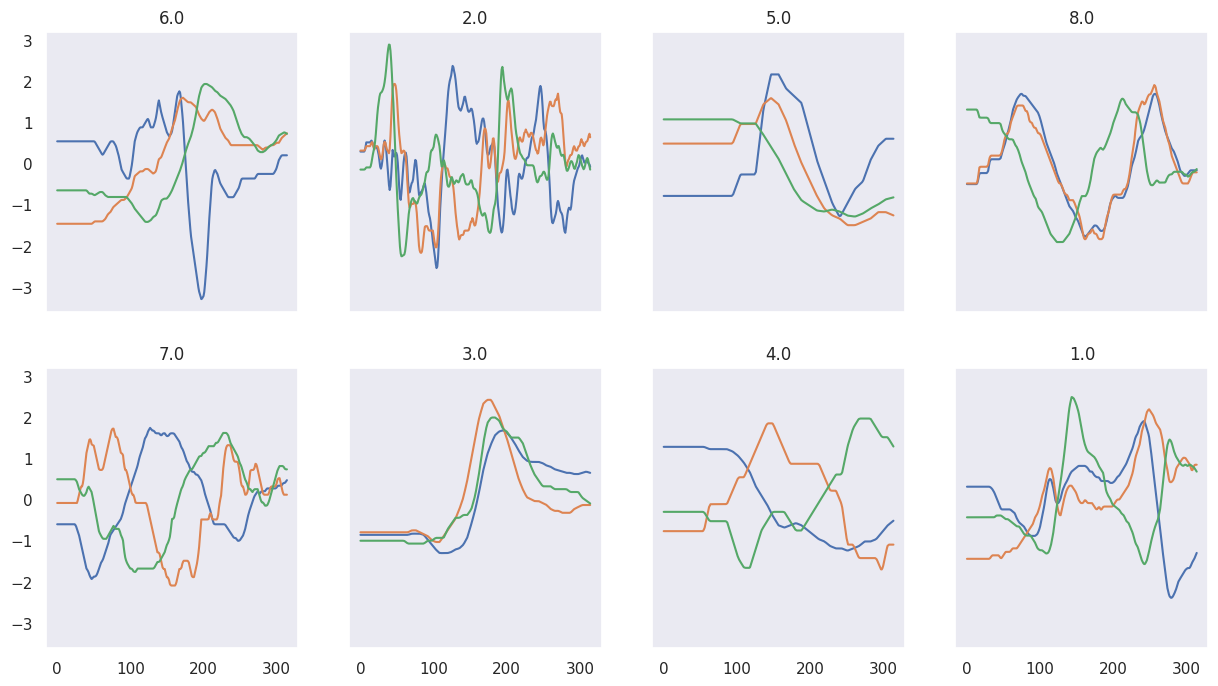

In [24]:
plot = True
x_plot = []
lab_plot = []
if plot:
  for lab in set_y_train:
    x_plot.append(X_train[np.where(y_train == lab)[0][0]])
    lab_plot.append(lab)

  fig, axs = plt.subplots(2, 4, figsize=(15,8), sharex=True, sharey=True)
  na = np.concatenate([axs[0], axs[1]])

  for i, ax in enumerate(na):
    sns.lineplot(ax=ax, data=x_plot[i][0])
    sns.lineplot(ax=ax,data=x_plot[i][1])
    sns.lineplot(ax=ax,data=x_plot[i][2])
    ax.set_title(lab_plot[i])
    ax.grid()

# ⚙ Structure



## Dataset

&emsp; &emsp;Now there is the tricky part, we have to create one avalanche dataset for the training and one for the testing.

We do that as follows:
1. convert data labels in integer form string, (starting form 0).
2. create the task labels based on the task classes. (Not Mandatory)(work in progress)
3. create the **Avalanche Dataset** form a TensorDataset with X and y
4. add targets to the avalanche dataset (`avds_train.targets = torch.from_numpy(y_train_int)`)
5. make the *Classification Dataset* with `make_classification_dataset(avds_train,task_labels=task_labels_train)` , passing the avalanche ds and the task labels they are not mandatory.

Now we have to do the same for the testing data.

In [25]:
from avalanche.benchmarks.utils import make_classification_dataset
from torch.utils.data.dataset import TensorDataset
from avalanche.benchmarks.utils import AvalancheDataset

# storing the parameter of our net
vars = X_train.shape[1]
out = len(set(y_train))

#converting labels from strings to int (avalance uses integers )
y_train_int = np.array([int(float(numeric_string)) for numeric_string in y_train])
y_test_int = np.array([int(float(numeric_string)) for numeric_string in y_test])
# y_train_int = np.array(y_int)[np.array(splits[0])]
# y_test_int = np.array(y_int)[np.array(splits[1])]
y_train_int = y_train_int -1
y_test_int = y_test_int -1

#task labels feature
# task_labels_train = []
# for y in y_train:
#   for idx, t in enumerate(task_classes_arr):
#     if y in t:
#       task_labels_train.append(idx)

# task_labels_test = []
# for y in y_test:
#   for idx, t in enumerate(task_classes_arr):
#     if y in t:
#       task_labels_test.append(idx)

#creating train ds
avds_train = AvalancheDataset(TensorDataset(torch.tensor(X_train),torch.from_numpy(y_train_int)))
avds_train.targets = torch.from_numpy(y_train_int)
sup_data_train_avds = make_classification_dataset(avds_train)

#creating test ds
avds_test = AvalancheDataset(TensorDataset(torch.tensor(X_test),torch.from_numpy(y_test_int)))
avds_test.targets = torch.from_numpy(y_test_int)
sup_data_test_avds = make_classification_dataset(avds_test)

In [26]:
#showing the ds just created
len(sup_data_train_avds[0]), sup_data_train_avds[0][1], sup_data_train_avds[0][0].shape


(3, tensor(0), torch.Size([3, 315]))

## Benchmark
[Original guide](https://avalanche.continualai.org/from-zero-to-hero-tutorial/03_benchmarks)

&emsp; &emsp;By `Benchmark` we mean a well-defined and carefully thought combination of a scenario with one or multiple datasets that we can use to asses our continual learning algorithms.

For our work we use a `nc_benchmark`.

**nc_benchmark**: given one or multiple datasets it creates a benchmark instance based on scenarios where New Classes (NC) are encountered over time. Notable scenarios that can be created using this utility include **Class-Incremental**, Task-Incremental and Task-Agnostic scenarios.

### Implementation

`nc_benchmark` needs:
- train dataset
- test dataset
- number for experiences

The `number for experiences` is the number of tasks that the model have to classifies.

Benchmark moreover introduces the concept of `stream`.

`streams` are iterable, indexable and sliceable objects that are composed of unique experiences. Experiences are batch of data (or "tasks") that can be provided with or without a specific task label.

Each stream can in turn be treated as an iterator that produces a unique `experience`, containing all the useful data regarding a batch or task in the continual stream our algorithms will face

**Interesting test to do**:

Set `numExp` to 1, like a single big classification problem (no more continual learning but its good to see the upperbound). (we did it later)

In [27]:
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
numExp = 4
#creating the scenario or benchamark
scenario = nc_benchmark(
    sup_data_train_avds, sup_data_test_avds, n_experiences=numExp, shuffle=True, seed=1234, task_labels=True
)

train_stream = scenario.train_stream
#showing the benchmark
for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {} batch {} -> train'.format(t, exp_id))
    print('This batch contains', len(training_dataset), ' samples\n',
          'of ', experience.classes_in_this_experience, " classes.")

Task 0 batch 0 -> train
This batch contains 30  samples
 of  [5, 7]  classes.
Task 1 batch 1 -> train
This batch contains 30  samples
 of  [2, 3]  classes.
Task 2 batch 2 -> train
This batch contains 30  samples
 of  [4, 6]  classes.
Task 3 batch 3 -> train
This batch contains 30  samples
 of  [0, 1]  classes.


## Model & strategy
[Original guide](https://avalanche.continualai.org/from-zero-to-hero-tutorial/04_training#how-to-use-strategies-and-plugins)

&emsp; &emsp;Quick definitions:
- **Strategies**: these are popular baselines already implemented for you which you can use for comparisons or as base classes to define a custom strategy.
- **Plugins**: these are classes that allow adding some specific behavior to your own strategy. The plugin system allows defining reusable components which can be easily combined (e.g. a replay strategy, a regularization strategy). They are also used to automatically manage logging and evaluation.

Now its time to call the model and create the strategy to solve our CL problem, in this case we will use InceptionTime and ICaRL, thanks to avalanche we can use their PLUGIN.

In particualar `ICaRL` plugin needs:
- feature_extractor: backbone part of the net (you can see in the [model definition](#scrollTo=97kXX-1OOH9b) how it is defined)
- classifier: like feature_extractor, needs to evaluate the goodness of a sample
- memory size: number of samples to store (rearshal stuff), (train_size, eval_size)
- train_epochs: #training epochs


In [28]:
#showing models parameter (inputs and outputs numbers)
vars, out

(3, 8)

In [29]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.models import SimpleMLP
from avalanche.training.supervised import ICaRL, Naive, CWRStar, Replay, GDumb, Cumulative, LwF, GEM, AGEM, EWC,  JointTraining
from avalanche.training.plugins import EWCPlugin
# model creation
model = InceptionTime(vars, out)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

naive = False
if naive:
  #naive strategy
  cl_strategy = Naive(
      model, optimizer, criterion,
      train_mb_size=100, train_epochs=10, eval_mb_size=100
    )
else:
  #iCaRL strategy
  cl_strategy = ICaRL(
      feature_extractor= model.feature_extractor, classifier=model.classifier, optimizer=optimizer, memory_size = 2000,
      buffer_transform = None, fixed_memory = True,
      train_mb_size=100, train_epochs=10, eval_mb_size=100
      )


## Train & Testing
[Original guide](https://avalanche.continualai.org/from-zero-to-hero-tutorial/04_training#training-and-evaluation-loops)

&emsp; &emsp;For the training we iterete on the train stream, that will give back the experience, and then we train on it for the number of epochs that we decided in the strategy.

After that we will evaluate the model on all the test set.

The results of the train and evalutation phases will be saved in the list `results`, we will use it to show our results!

In [30]:
# TRAINING LOOP
print('Starting experiment...')
results = []

exp_classes = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    exp_classes.append(experience.classes_in_this_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    #training step
    cl_strategy.train(experience)
    print('Training completed')
    #testing step
    print('Computing accuracy on the whole test set')
    results.append(cl_strategy.eval(scenario.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [5, 7]
-- >> Start of training phase << --
100%|██████████| 1/1 [00:04<00:00,  4.22s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6836
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:02<00:00,  2.31s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6818
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:02<00:00,  2.54s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6783
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:04<00:00,  4.74s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6733
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:04<00:00,  4.01s/it]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6671
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:04

## Results

Now with the list `results`, that's contains all the outcomes, we have to extract

In [31]:
#Extracting informations from result dict
temp_task_acc = np.zeros(numExp)
temp_task_acc[:] = np.nan
Acc_over_Tasks = []
path = "Top1_Acc_Exp/eval_phase/test_stream"
for i, result in enumerate(results):
  if naive: path = f'Top1_Acc_Exp/eval_phase/test_stream/Task00{i}/Exp00{i}'
  for j, val in  enumerate([value for  key, value in result.items() if path in key]):
    temp_task_acc[i if naive else j] = np.nan if val == 0 else val

  Acc_over_Tasks.append(temp_task_acc)
  temp_task_acc = np.zeros(numExp)
  temp_task_acc[:] = np.nan
#for full joint we need the avarage accuracy
if numExp == 1:
  Acc_over_Tasks =[ [np.mean(Acc_over_Tasks)]]
Acc_over_Tasks

[array([0.75,  nan,  nan,  nan]),
 array([0.7125, 0.3625,    nan,    nan]),
 array([0.65, 0.4 , 0.45,  nan]),
 array([0.65  , 0.3875, 0.5375, 0.8   ])]

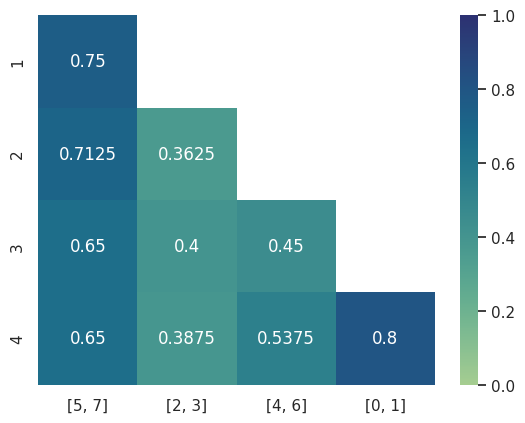

In [32]:
import seaborn as sns
sns.set_style(style='white')

nan_mask = np.isnan(Acc_over_Tasks)
sns.heatmap(Acc_over_Tasks, vmin=0, vmax=1,mask = nan_mask, annot=True,fmt='g',
            yticklabels=range(1, numExp+1), xticklabels=exp_classes, cmap="crest")
plt.show()

# ☕ MULTI STRATEGY COMPARE

&emsp; &emsp;After having introduced the general functioning, it's time to move on to the most interesting things and make a comparison between the `Naive` and Continal Learning, we will also add an accuracy UpperBound level given by the **full joint**.



## Set Up

Hyper and some config vars
- `numExp`: number of experiences
- `numEpochs`: number of epochs fo train
- `strat_type`: type of the strategy
- `names`: names of the strategies (for plots)

In [ ]:
numExp = 4
numEpochs = 25
strat_type = ['naive', None, 'fulljoint']
names = ['Naive', 'ICaRL', 'Full Joint']

### Scenarios

- **Naive**: Learn one task as a single task to do.
- **iCaRL**: Use iCaRL method to learn Incrementally the tasks.
- **Full joint**: Learn all data as a single task all together.

In [ ]:
#creating scenarios for 3 approachs
#we also swapped train with test because test set has more istances 320 vs 120 of the train set
ICaRL_scenario = nc_benchmark(
    sup_data_test_avds, sup_data_train_avds, n_experiences=numExp, shuffle=True, seed=1234, task_labels=True
)

Naive_scenario = nc_benchmark(
    sup_data_test_avds, sup_data_train_avds, n_experiences=numExp, shuffle=True, seed=1234, task_labels=True
)

FullJoint_scenario = nc_benchmark(
    sup_data_test_avds, sup_data_test_avds, n_experiences=1, shuffle=True, seed=1234, task_labels=True
)

### Models & Strategy

Model:
- InceptionTime

Strategies:
- Naive
- iCaRL
- Full joint

In [ ]:

model = InceptionTime(vars, out)
#here we change the filter length no more 10 20 40 but 16 32 64 you can change it as you want, its based on dataset, check InceptionTime paper for more info
model.inceptionblock = InceptionBlock(vars, nf=32, ks=64 )

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

Naive_strategy = Naive(
      model, optimizer, criterion,
      train_mb_size=100, train_epochs=numEpochs, eval_mb_size=100
    )

FullJoint_strategy = JointTraining(
      model, optimizer, criterion,
      train_mb_size=100, train_epochs=numEpochs, eval_mb_size=100
    )

ICaRL_strategy = ICaRL(
      feature_extractor= model.feature_extractor, classifier=model.classifier, optimizer=optimizer, memory_size = 2000,
      buffer_transform = None, fixed_memory = True,
      train_mb_size=100, train_epochs=numEpochs, eval_mb_size=100
      )

## Train

&emsp; &emsp;We have create a function to wrap up the train so we can just call a function to train different scenarios and strategies.

Remember to modify `strat_type` in order to get the right values after the evaluation.



In [ ]:
def wrapTrain(scenario, strategy):
  exp_classes = []
  results = []
  for experience in progress_bar(scenario.train_stream):
    exp_classes.append(experience.classes_in_this_experience)
    strategy.train(experience)
    results.append(strategy.eval(scenario.test_stream))

  return results, exp_classes

In [ ]:
Naive_results, Naive_exp_classes = wrapTrain(Naive_scenario, Naive_strategy)

ICaRL_results, ICaRL_exp_classes =  wrapTrain(ICaRL_scenario,ICaRL_strategy)

FullJoint_results, FullJoint_classes =  wrapTrain(FullJoint_scenario, FullJoint_strategy)

results_Tot = [Naive_results,ICaRL_results,FullJoint_results]
exp_classes_Tot = [Naive_exp_classes,ICaRL_exp_classes,FullJoint_classes]


-- >> Start of training phase << --
100%|██████████| 1/1 [00:04<00:00,  4.56s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.0894
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0875
100%|██████████| 1/1 [00:07<00:00,  7.95s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.0414
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1125
100%|██████████| 1/1 [00:05<00:00,  5.23s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.9532
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1500
100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8373
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2125
100%|██████████| 1/1 [00:04<00:00,  4.83s/it]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.7073
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3625
100%|██████████| 1/1 [00:05<00:00,  5.38s/it]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/T

-- >> Start of training phase << --
100%|██████████| 1/1 [00:06<00:00,  6.16s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9828
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:05<00:00,  5.72s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9804
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:03<00:00,  3.10s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9758
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:03<00:00,  3.38s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9694
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:03<00:00,  3.70s/it]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9613
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/T

-- >> Start of training phase << --
100%|██████████| 4/4 [00:19<00:00,  4.99s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.7153
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2500
100%|██████████| 4/4 [00:18<00:00,  4.68s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6213
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3031
100%|██████████| 4/4 [00:18<00:00,  4.51s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5129
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4625
100%|██████████| 4/4 [00:18<00:00,  4.52s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4152
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6625
100%|██████████| 4/4 [00:18<00:00,  4.51s/it]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3209
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7781
100%|██████████| 4/4 [00:18<00:00,  4.58s/it]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/T

## Results

In [ ]:
def plot_results(ax, results, exp_classes, strat_type = None, numExp = 4, title = 'HeatMap'):
  if ax == None:
    ax = plt.subplot(111)
  if not strat_type is None: strat_type =  strat_type.lower()
  if strat_type == "fulljoint":
      numExp = 1

  temp_task_acc = np.zeros(numExp)
  temp_task_acc[:] = np.nan
  Acc_over_Tasks = []
  path = "Top1_Acc_Exp/eval_phase/test_stream"
  for i, result in enumerate(results):
    if strat_type == 'naive': path = f'Top1_Acc_Exp/eval_phase/test_stream/Task00{i}/Exp00{i}'
    for j, val in  enumerate([value for  key, value in result.items() if path in key]):
      temp_task_acc[i if strat_type == 'naive' else j] = np.nan if val == 0 else round(val, 2)

    Acc_over_Tasks.append(temp_task_acc)
    temp_task_acc = np.zeros(numExp)
    temp_task_acc[:] = np.nan

  if strat_type == "fulljoint":
    Acc_over_Tasks = [[np.mean(Acc_over_Tasks)]]


  nan_mask = np.isnan(Acc_over_Tasks)
  sns.heatmap(Acc_over_Tasks, vmin=0, vmax=1,mask = nan_mask, annot=True,fmt='g',
              yticklabels=range(1, numExp+1), xticklabels=exp_classes, cmap="crest", ax=ax)
  ax.set_title(title)

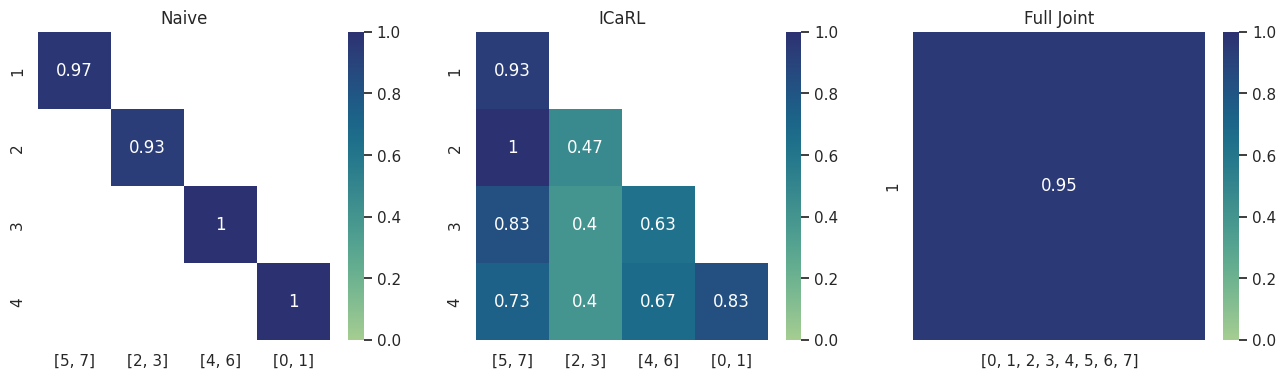

In [ ]:
fig, axs = plt.subplots(1, len(results_Tot), figsize=(16,4)) #fix grid
for i, ax in enumerate(axs):
  plot_results(ax, results_Tot[i], exp_classes_Tot[i], strat_type = strat_type[i], numExp = numExp, title = names[i] )
plt.show()


## Result comments

&emsp; &emsp;As we can see the form the graphs the first task starts well, near the Naive (the difference is due to the starting point prolly), then it growns to 1, with the second task, this is due to iCaRL, as all replay methods it makes the model able to keep learn an old task thank to the reppresentative train set.

The most critic accuracy loss is when we learn the third task [4, 6], this is due to the difference between the two tasks, this is also the cause of low accuracy on task 3.

The other task has not high forgetting (the third had a small improve), so we can say that the iCaRL technique is working enough well.

The right hand graph its the average accuracy over all tasks if we had all data together, thats mean the problem was not that hard.


## Future Works

* As first i suggest to implement the `task_labels` feature, so you can test how much cares the initial point/task for the CL problems.
* Then i suggest to insert another CL Plugin to make a comparison between CL Techniques, you have just to change the plugin in the strategy.